In [1]:
import openfst_python as fst
from IPython.display import Image
from subprocess import check_call
import turkish_fst.fst as tr_fst

In [2]:
def draw_fst(f: fst.Fst, output_file :str) -> None:
    dot_file = f'{output_file}.dot'
    png_file = f'{output_file}.png'
    f.draw(dot_file, portrait=True)
    check_call(['dot','-Tpng','-Gdpi=200', dot_file,'-o', png_file])

# The Language

This is a subset of Turkish language comprising eleven custom word, and the morphology rules plural suffix and possessive suffix.

In [3]:
# Define the root lexicon
lexicon = [
    "kapı", # Niv
    "kitap", # Nic
    "piyano", # Nuv
    "kuş", # Nuc
    "kedi", # Niiv
    "ev", # Niic
    "öykü", # Nuuv
    "göz", # Nuuc
    "sarnıç", # Nic
    "kağıt", # Nic
    "toprak", # Nic
]

The final state transducer (FST) design is structured around eight distinct word classes: Niv, Nic, Nuv, Nuc, Niiv, Niic, Nuuv, and Nuuc. This design strategically employs knowledge about the last vowel in these classes to handle both plural and possessive suffixes. 

In the classification of word classes, 'i' specifically represents the Turkish vowel 'ı', 'ii' represents 'i', 'u' stands for 'u', and 'uu' is indicative of the Turkish vowel 'ü'. The choice of these letters within these classes determines the suffix added to form the possessive structure of a word, which can either precede the word or be embedded within it. For instance, consider the word ‘kapı’, which ends with the vowel ‘ı’. In its second singular possessive form, the suffix also takes the letter ‘ı’, resulting in ‘kapısı’. Another example is the word ‘göz’, ending with a consonant, yet its last vowel is ‘ü’. When forming its first singular possessive form, it changes to ‘gözüm’. These examples highlight how the specific vowel used in the possessive suffix directly correlates with the last vowel in the word.

# Creating the FST

## Vocabulary FST

Following the definition of the word classes, a sample lexicon containing eleven Turkish words is established, and an FST is generated. Each word is linked to its corresponding word class as the final state. Subsequently, it becomes straightforward to append our plural and possessive rules to the existing lexicon FST.

In [4]:
my_fst = tr_fst.TurkishFST(lexicon)

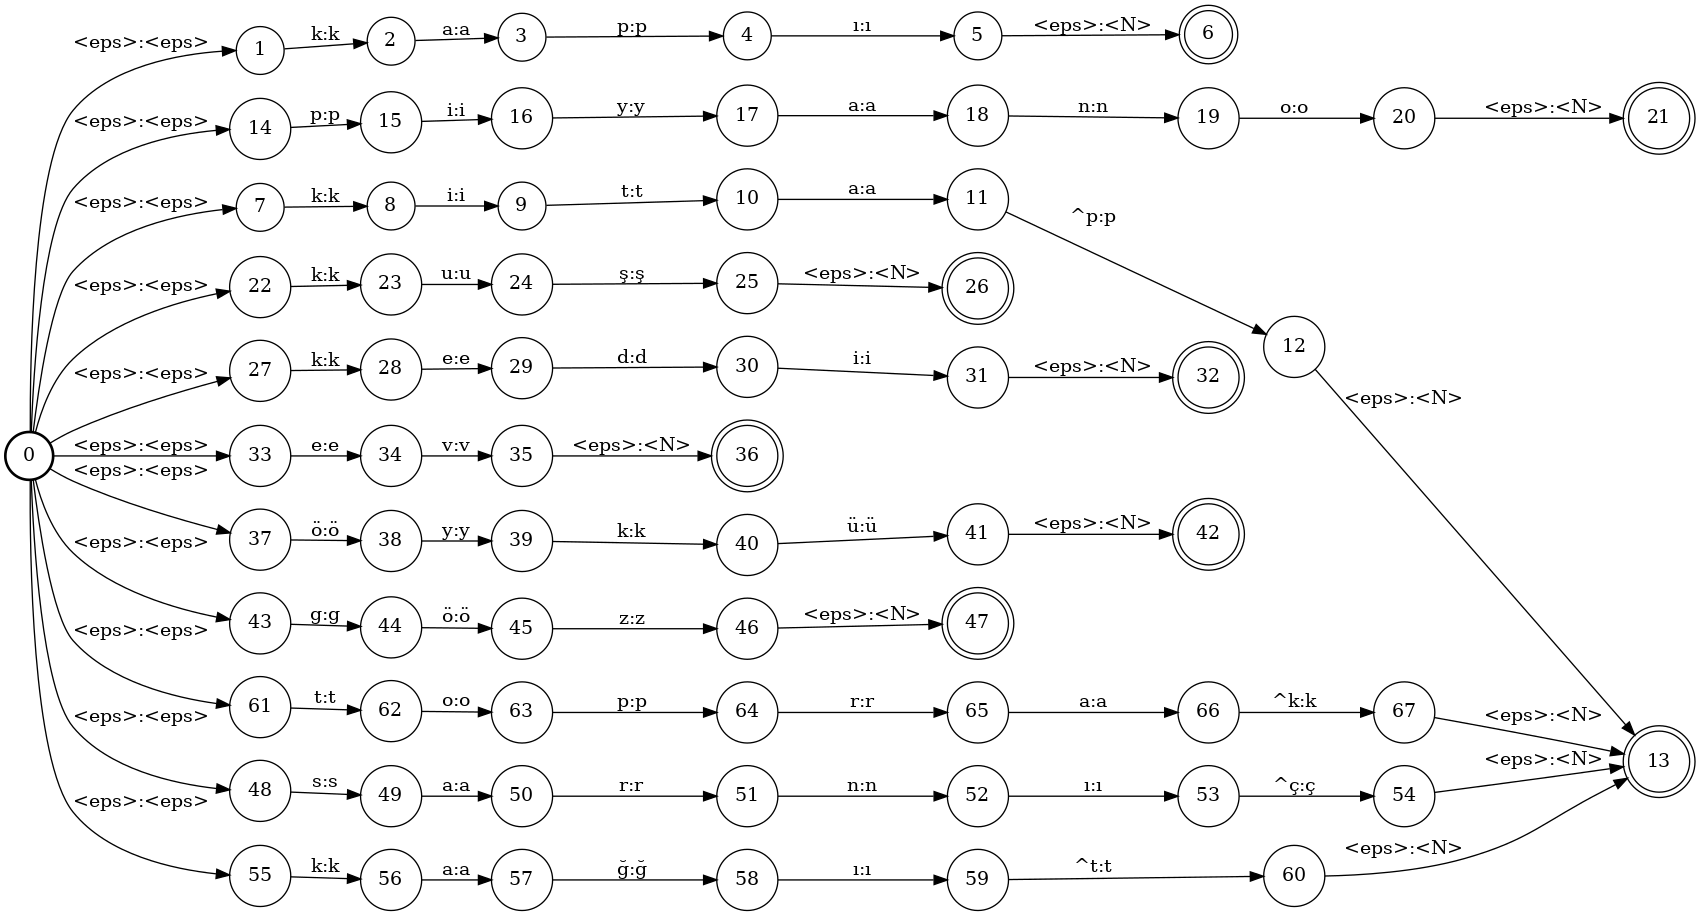

In [5]:
draw_fst(my_fst.f, "lexicon_fst")
Image(filename="lexicon_fst.png")

## Plural Suffix

In Turkish, the plural suffix generally adds "-ler" or "-lar" to the noun base depending on vowel harmony. If the last vowel in the noun is unrounded (a, ı, o, u), you add "-lar" for the plural; if it's rounded (e, i, ö, ü), you use "-ler". Additionally, certain vowels may undergo changes due to vowel harmony rules when the plural suffix is added, ensuring harmony between the suffix and the noun stem.

The plural rule operates quite simply: append new arcs as suffixes 'ler' and 'lar' from the word class states, gather them together, and introduce an epsilon transition with the output plural tag.  

In [6]:
my_fst.append_plural_fst()

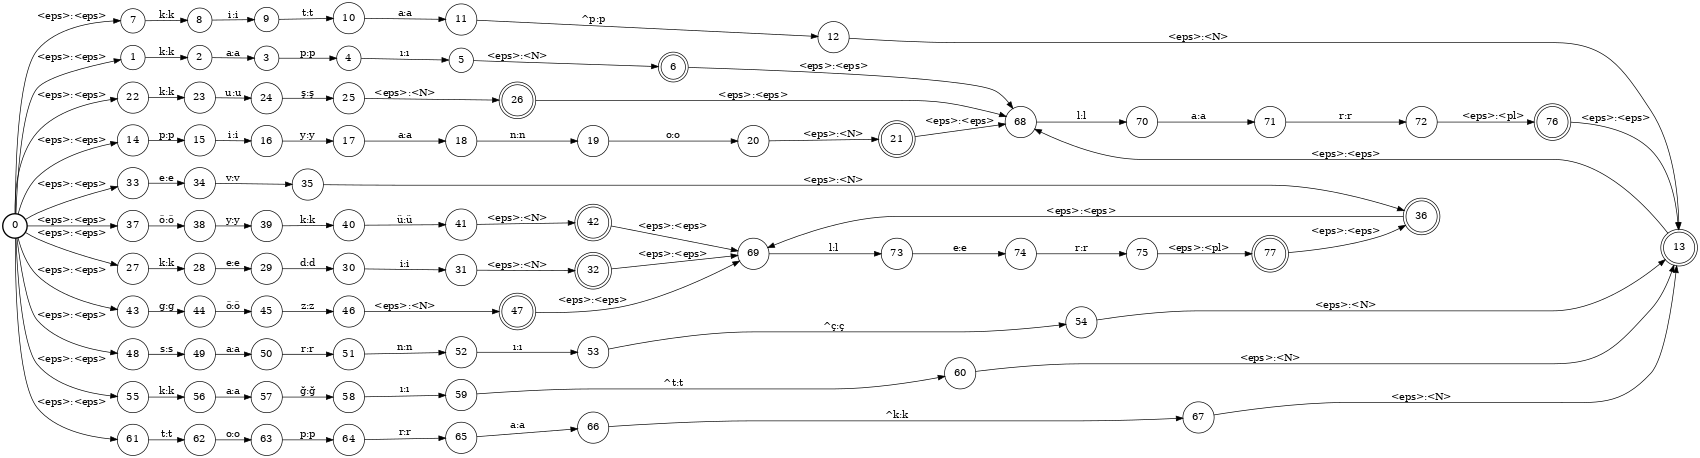

In [7]:
draw_fst(my_fst.f, "plural_fst")
Image(filename="plural_fst.png")

## Possessive Suffix

Possessive suffixes in Turkish add information like “my school” or “his car” to words. They follow Vowel Harmony rules, like the verb “to be”. If a word ends in a vowel, “my” gets -m and “your” gets -n without an extra vowel. For words ending in certain vowels, the suffix vowel matches the last vowel of the word. Consonant-ending words need a vowel before the suffix. When a word ends in a consonant, “his/her/its” drops the 's' from the suffix. “Their” keeps its suffix as -leri/-ları, regardless of word ending. 

The possessive rule relies on both the final vowel and the ending letter, whether it's a vowel or consonant. It involves gathering possessive suffixes based on the word class and adding new arcs from the word class states. The termination point of the suffix node is connected to an epsilon transition to generate the possessive form as output.

In [8]:
my_fst.append_possessive_fst()

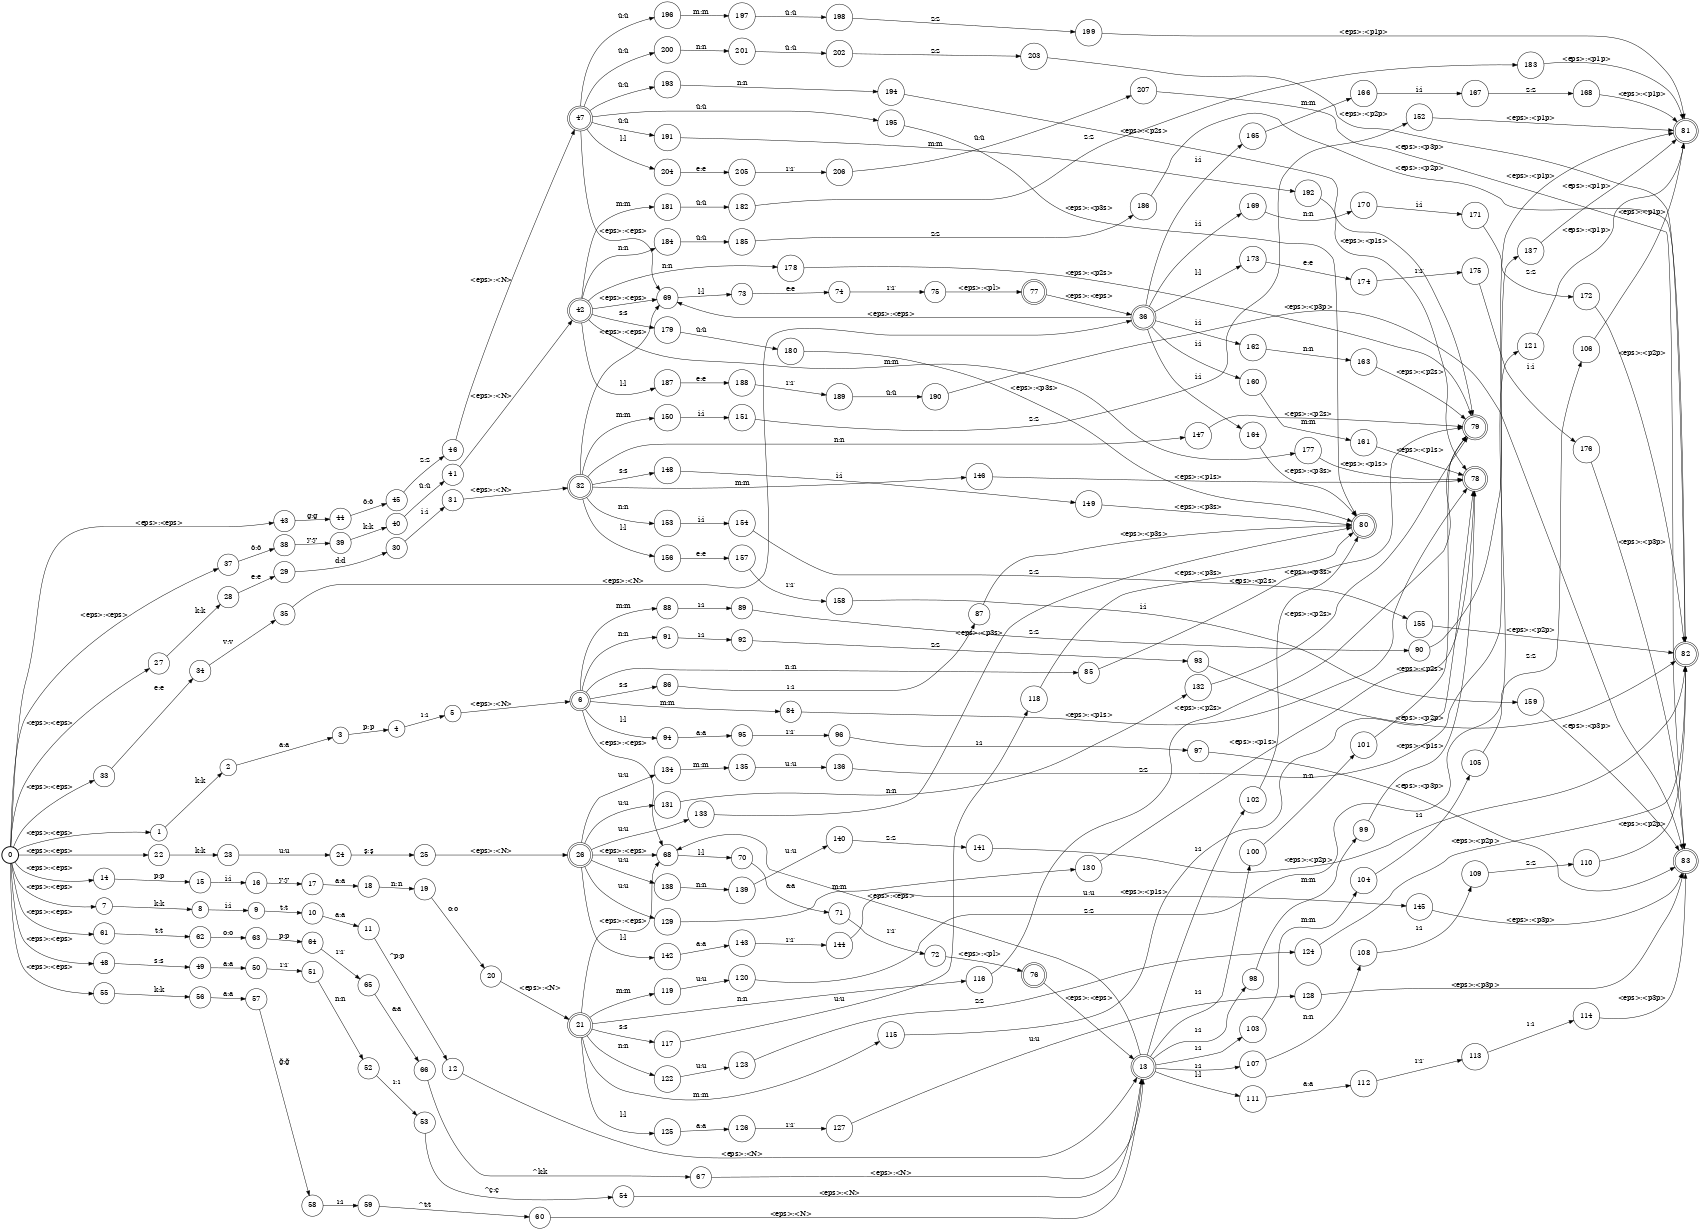

In [9]:
draw_fst(my_fst.f, "poss_fst")
Image(filename="poss_fst.png")

# Morphological Analysis (Surface to Lexical)

The obtained outcomes align with expectations, indicating that the generated Finite State Transducer accurately performs morphological analysis on the defined lexicon based on the specified rules.

In [10]:
test_words = [
    "kapılar", 
    "kapıları", 
    "kitabım", 
    "kitab",
    "kitaplarım", 
    "kitablarım", 
    "kuşun", 
    "kuşumuz",
    "kuşların", 
    "kedileri",
    "kedim", 
    "kedi", 
    "cat",
    "evimiz", 
    "evden",
    "evinden",
    "öykümüz",
    "öykünüz",
    "göz",
    "gözlerin",
    "gözü",
    "sarnıçlarımız", 
    "sarnıcın", 
    "kağıtları", 
    "kağıdım", 
    "toprakları", 
    "toprağımız", 
    "toprakımız",
    "TOPRAKLARIMIZ",
    "%cscd",
]

for i, word in enumerate(test_words):
    lex_forms = my_fst.morphological_analyzer(word)
    print(f"\n{i + 1}.) {word}: {'' if lex_forms else 'REJECT'}")
    for form in lex_forms:
        print(form)


1.) kapılar: 
kapı<N><pl>

2.) kapıları: 
kapı<N><pl><p3s>
kapı<N><p3p>

3.) kitabım: 
kitap<N><p1s>

4.) kitab: REJECT

5.) kitaplarım: 
kitap<N><pl><p1s>

6.) kitablarım: 
kitap<N><pl><p1s>

7.) kuşun: 
kuş<N><p2s>

8.) kuşumuz: 
kuş<N><p1p>

9.) kuşların: 
kuş<N><pl><p2s>

10.) kedileri: 
kedi<N><pl><p3s>
kedi<N><p3p>

11.) kedim: 
kedi<N><p1s>

12.) kedi: 
kedi<N>

13.) cat: REJECT

14.) evimiz: 
ev<N><p1p>

15.) evden: REJECT

16.) evinden: REJECT

17.) öykümüz: 
öykü<N><p1p>

18.) öykünüz: 
öykü<N><p2p>

19.) göz: 
göz<N>

20.) gözlerin: 
göz<N><pl><p2s>

21.) gözü: 
göz<N><p3s>

22.) sarnıçlarımız: 
sarnıç<N><pl><p1p>

23.) sarnıcın: 
sarnıç<N><p2s>

24.) kağıtları: 
kağıt<N><pl><p3s>
kağıt<N><p3p>

25.) kağıdım: 
kağıt<N><p1s>

26.) toprakları: 
toprak<N><p3p>
toprak<N><pl><p3s>

27.) toprağımız: 
toprak<N><p1p>

28.) toprakımız: REJECT

29.) TOPRAKLARIMIZ: 
toprak<N><pl><p1p>

30.) %cscd: REJECT
